In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as  TF
import medmnist
from medmnist import INFO
import pytorch_lightning as pl
import PIL
import torch
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision


In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as  TF
import medmnist
from medmnist import INFO
import pytorch_lightning as pl
import PIL
import torch
import random

class PairedCnMedMNIST2D(Dataset):
    def __init__(self, data, transform, split, x2_angle, test_all_rotations=False):
        """
        Args:
        data: MedMNIST dataset object. In particular, this class assumes that the dataset object has the following attributes:
            - imgs: List of PIL images
            - labels: List of labels
        transform: Transform to apply to the images
        Split: 'train', 'val', or 'test'
        x2_angle: Angle to rotate the second image by
        """
        self.data = data
        self.split = split
        self.x2_angle = x2_angle
        self.test_all_rotations = test_all_rotations
        self.transform = transform
        assert 360 % x2_angle == 0, "x2_angle must divide 360 evenly"

        self.rotation_indices = [i for i in range(int(360/x2_angle))]

    def __len__(self):
        """
        If self.test_all_rotations is True, for val and test we return the number of images in the dataset times the number of rotations
        Otherwise, we return the number of images
        """
        if self.test_all_rotations:
            if self.split == 'train':
                return len(self.data.imgs)
            else:
                return len(self.data.imgs) * len(self.rotation_indices)
        else:
            return len(self.data.imgs)
    
    def affine_transform(self, image, angle, scale, shear, x_displacement=0, y_displacement=0):
        # x,y displacement is useless if we use a CNN since it's translation invariant
        return TF.affine(image, angle, [x_displacement, y_displacement], scale, shear, interpolation=TF.InterpolationMode.BILINEAR)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            x1, y1 = self.data.imgs[idx], self.data.labels[idx][0]
            x1 = self.transform(x1)
            label = y1
            augment_angle_covariate = random.randint(0, int(360/self.x2_angle)-1)
            augment_angle = augment_angle_covariate * self.x2_angle
            scale = 1.0
            augmented_X1 = self.affine_transform(x1, angle=augment_angle, scale=scale, shear=0)
            y1 = torch.tensor([label, augment_angle_covariate])
            
            transformation_type = 0
            # Here introduces soft constraints if range = [1, 360/x2_angle], as we get W^N
            covariate = random.randint(1, int(360/self.x2_angle)-1)
            x2_angle = (augment_angle_covariate+covariate)%int(360/self.x2_angle) * self.x2_angle
            target_angle = int(x2_angle/self.x2_angle)
            y2 = torch.tensor([label, target_angle])
            transformed_X2 = self.affine_transform(x1, angle=x2_angle, scale=scale, shear=0)
        
        else:
            
            if self.test_all_rotations:
                img_idx = idx // len(self.rotation_indices)
                x1, y1 = self.data.imgs[img_idx], self.data.labels[img_idx][0]
                label = y1
                x1 = self.transform(x1)
                rotation_idx = idx % len(self.rotation_indices) 

                augment_angle_covariate = self.rotation_indices[rotation_idx]
                augment_angle = augment_angle_covariate * self.x2_angle
                scale = 1.0
                augmented_X1 = self.affine_transform(x1, angle=augment_angle, scale=scale, shear=0)
                y1 = torch.tensor([label, augment_angle_covariate])
                
                transformation_type = 0
                covariate = random.randint(1, int(360/self.x2_angle)-1)
                x2_angle = (augment_angle_covariate+covariate)%int(360/self.x2_angle) * self.x2_angle
                target_angle = int(x2_angle/self.x2_angle)
                y2 = torch.tensor([label, target_angle])
                transformed_X2 = self.affine_transform(x1, angle=x2_angle, scale=scale, shear=0)

            else:
                x1, y1 = self.data.imgs[idx], self.data.labels[idx][0]
                label = y1
                x1 = self.transform(x1)
                augmented_X1 = x1
                y1 = torch.tensor([label, 0])
                transformed_X2 = x1
                y2 = torch.tensor([label, 0])
                transformation_type = 0
                covariate = 0

        return (augmented_X1, y1), (transformed_X2, y2), transformation_type, covariate



class CnMedMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_flag, batch_size, resize, as_rgb, size, download, x2_angle):
        super().__init__()
        self.data_flag = data_flag
        self.batch_size = batch_size
        self.resize = resize
        self.as_rgb = as_rgb
        self.size = size
        self.download = download
        self.info = INFO[data_flag]
        self.DataClass = getattr(medmnist, self.info['python_class'])
        self.x2_angle = x2_angle
        assert 360 % x2_angle == 0, "x2_angle must divide 360 evenly"

        print(f"Using x2 angle = {self.x2_angle}")
        
        if resize:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST),
                transforms.ToTensor(),
                transforms.Normalize(mean=[.5], std=[.5])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[.5], std=[.5])
            ])

    def setup(self, stage=None):
        train_data = self.DataClass(split='train', transform=self.transform, download=self.download, as_rgb=self.as_rgb, size=self.size)
        self.train_dataset = PairedCnMedMNIST2D(train_data, transform=self.transform, split='train', x2_angle=self.x2_angle)

        val_data = self.DataClass(split='val', transform=self.transform, download=self.download, as_rgb=self.as_rgb, size=self.size)
        self.val_dataset = PairedCnMedMNIST2D(val_data, transform=self.transform, split='val', x2_angle=self.x2_angle)

        test_data = self.DataClass(split='test', transform=self.transform, download=self.download, as_rgb=self.as_rgb, size=self.size)
        self.test_dataset = PairedCnMedMNIST2D(test_data, transform=self.transform, split='test', x2_angle=self.x2_angle)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=15)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=15)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=15)
    


Using x2 angle = 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8431371..0.9372549].


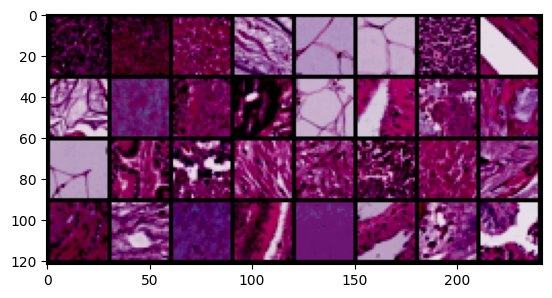

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8431371..0.9372549].


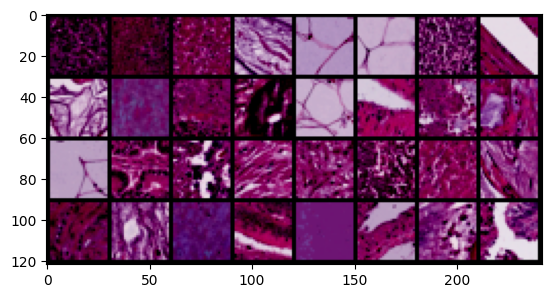

tensor([1, 1, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 1, 1, 2, 2, 3, 3, 1, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 3, 2, 2, 1])


In [8]:
data_module = CnMedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=False, x2_angle=90)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


for i, ((x1, y1), (x2, y2), transformation_type, covariate) in enumerate(train_loader):
    break

imshow(torchvision.utils.make_grid(x1))
imshow(torchvision.utils.make_grid(x2))
print(covariate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.9529412].


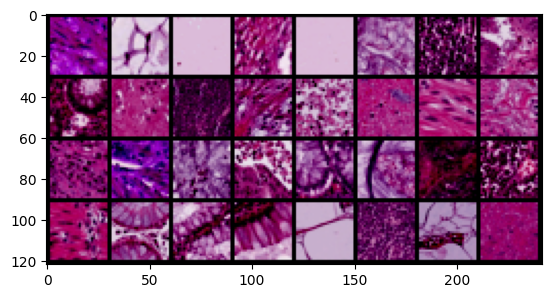

In [5]:
from datasets.MedMNIST2D_dataset import MedMNISTDataModule
data_module = MedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=False)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

for i, (x, y) in enumerate(val_loader):
    break

imshow(torchvision.utils.make_grid(x))


In [4]:
from models.FunctorModel import FunctorModel

dir = '/home/rma55/git-repos/MedMNIST_functorial/tb_logs/pathmnist/functor/model1_resnet18_lambdaT_0.5_lambdaW_0.5/version_0/checkpoints/best_model.ckpt'
model = FunctorModel.load_from_checkpoint(dir).cpu()
model.eval()
print(torch.dist(torch.linalg.matrix_power(model.W, 4), torch.eye(model.W.shape[0])))
print()

tensor(0.9735, grad_fn=<DistBackward0>)



In [ ]:
_, latent1 = model(x1)
_, latent2 = model(x2)
# transformed_latents = [] 
# for i, c in enumerate(covariate):
#     transformed_latent = torch.linalg.matrix_power(model.W, c) @ latent1[i]
#     transformed_latents.append(transformed_latent)
# transformed_latents = torch.stack(transformed_latents)
transformed_latents = model.get_transformed_latent(latent1, covariate, covariate)
print(torch.nn.functional.mse_loss(latent2, transformed_latents).item())
print(torch.dist(latent2, transformed_latents).item())
print(torch.norm(latent2 - transformed_latents, dim=1))
print(torch.dist(torch.linalg.matrix_power(model.W, 4), torch.eye(model.W.shape[0])).item())
# eigvals, _ = torch.linalg.eig(model.W)
# print((eigvals**4-1).abs())

0.000944483675993979
3.933753490447998
tensor([0.4312, 0.5625, 0.6843, 0.4628, 0.6164, 0.5202, 0.6997, 1.0269, 0.6345,
        0.6354, 0.7803], grad_fn=<IndexBackward0>)
0.9735057353973389


In [43]:
img = x1[0]
_, img_latent = model(img.unsqueeze(0))

# rotate img by 90, 180, 270 degrees
rotated_imgs = []
for i in range(1, 4):
    rotated_imgs.append(TF.rotate(img, i*90))
rotated_imgs = torch.stack(rotated_imgs)
_, rotated_latents = model(rotated_imgs)
covariates = torch.tensor([1, 2, 3])

# Repeat img_latent 3 times
img_latent_repeated = img_latent.repeat(3, 1)
transformed_latents = model.get_transformed_latent(img_latent_repeated, covariates, covariates)
print(torch.norm(rotated_latents - transformed_latents, dim=1))
print(torch.nn.functional.mse_loss(rotated_latents, transformed_latents).item())

tensor([0.4701, 0.5446, 0.5440], grad_fn=<LinalgVectorNormBackward0>)
0.0005295871524140239


In [ ]:
from utils.char_tables import Cn_CharTable
cn_table = Cn_CharTable(4)

cn_table.calculate_irreducible_reps_dimensions(model.W)

[129, 128, 127, 128]